In [1]:
# !pip install langdetect

In [2]:
# !pip install vaderSentiment

In [3]:
# !pip install transformers

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from langdetect import detect
import getpass
from sqlalchemy import create_engine
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter

In [5]:
password = getpass.getpass()

 ········


In [6]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/air_bnb_reviews'
engine = create_engine(connection_string)

In [7]:
query = 'SELECT * FROM air_bnb_berlin'

In [8]:
df = pd.read_sql_query(query, engine)
df.head(30)

,index,review_id,review_date,reviewer_id,reviewer_name,comments,listing_id,listing_url,listing_name,host_id,...,last_review,overall_rating,accuracy_rating,cleanliness_rating,checkin_rating,communication_rating,location_rating,value_rating,instant_bookable,business_travel_ready
0,0,58660447,2016-01-03,14876562,Dennis,"Very nice, clean appartement! Josh was really ...",10002699,https://www.airbnb.com/rooms/10002699,Trendy and peaceful KreuzkÃ¶lln,44696672,...,2016-01-03,100,8,10,6,10,10,10,f,f
1,2,58663795,2016-01-03,49367757,Andreea,Aki is really nice and friendly. We had an ama...,10006647,https://www.airbnb.com/rooms/10006647,Very central and very quite,40791092,...,2017-02-12,92,9,8,9,10,10,9,f,f
2,3,59003619,2016-01-05,46694292,Sasha,Aki is a very nice dude with a clean place in ...,10006647,https://www.airbnb.com/rooms/10006647,Very central and very quite,40791092,...,2017-02-12,92,9,8,9,10,10,9,f,f
3,4,66845661,2016-03-25,54542819,Yohana,Aki's place was easy to find and located in th...,10006647,https://www.airbnb.com/rooms/10006647,Very central and very quite,40791092,...,2017-02-12,92,9,8,9,10,10,9,f,f
4,5,67969785,2016-04-01,35352843,Mitchell,We had to wait 30mins for Aki to arrive but ot...,10006647,https://www.airbnb.com/rooms/10006647,Very central and very quite,40791092,...,2017-02-12,92,9,8,9,10,10,9,f,f
5,6,68816282,2016-04-06,48006291,Cindy,"Great room, very comfortable and clean. Aki an...",10006647,https://www.airbnb.com/rooms/10006647,Very central and very quite,40791092,...,2017-02-12,92,9,8,9,10,10,9,f,f
6,7,69289363,2016-04-10,63759402,Marco,Aki was really friendly and available giving u...,10006647,https://www.airbnb.com/rooms/10006647,Very central and very quite,40791092,...,2017-02-12,92,9,8,9,10,10,9,f,f
7,8,69780867,2016-04-13,53960263,Santiago,Aki es sin duda el mejor host q uno puede tene...,10006647,https://www.airbnb.com/rooms/10006647,Very central and very quite,40791092,...,2017-02-12,92,9,8,9,10,10,9,f,f
8,9,70426866,2016-04-17,26184931,Eduardo,"We did not meer Aki, but we did meet Fabián, h...",10006647,https://www.airbnb.com/rooms/10006647,Very central and very quite,40791092,...,2017-02-12,92,9,8,9,10,10,9,f,f
9,10,78320875,2016-06-06,12388715,Luke,Aki was an awesome host in Berlin. We got alon...,10006647,https://www.airbnb.com/rooms/10006647,Very central and very quite,40791092,...,2017-02-12,92,9,8,9,10,10,9,f,f


Using langdetect I am going to count the comments rows based on their language. Before that for performances reasons (I cannot use the whole df), I am going to select all the reviews that belong to the top 2000 rated properties and the 2000 least rated properties. I am going to analyse if we can spot some differences.

In [10]:
df_os_sorted = df.sort_values(by='overall_rating', ascending=False)
top_500_unique_listing_ids = df_os_sorted['listing_id'].unique()[:2000]
best_rated = df[df['listing_id'].isin(top_500_unique_listing_ids)]

In [11]:
best_rated.head()

,index,review_id,review_date,reviewer_id,reviewer_name,comments,listing_id,listing_url,listing_name,host_id,...,last_review,overall_rating,accuracy_rating,cleanliness_rating,checkin_rating,communication_rating,location_rating,value_rating,instant_bookable,business_travel_ready
0,0,58660447,2016-01-03,14876562,Dennis,"Very nice, clean appartement! Josh was really ...",10002699,https://www.airbnb.com/rooms/10002699,Trendy and peaceful KreuzkÃ¶lln,44696672,...,2016-01-03,100,8,10,6,10,10,10,f,f
19556,19730,74177909,2016-05-13,49290567,Johannes,Trotz deutlicher Verspà¤tung bei der Anreise w...,11328533,https://www.airbnb.com/rooms/11328533,Charming tiny house close to lakes,59278295,...,2019-03-25,100,10,10,10,10,9,8,f,f
19557,19731,428556530,2019-03-25,229218552,Florian,Alles in allem ein wirklich schà¶nes Domizil m...,11328533,https://www.airbnb.com/rooms/11328533,Charming tiny house close to lakes,59278295,...,2019-03-25,100,10,10,10,10,9,8,f,f
19622,19796,64944440,2016-03-09,49407647,Tugce,Alexandra's apartment is comfortable and she w...,11337277,https://www.airbnb.com/rooms/11337277,GemÃ¼tliches Zimmer in WG zu vegeben,48503637,...,2016-03-09,100,10,10,10,10,10,10,f,f
19775,19951,65638467,2016-03-16,34740943,Angeline,Accueil chaleureux dans une chambre très grand...,11348934,https://www.airbnb.com/rooms/11348934,GroÃes Zimmer im Herzen Berlins,59430981,...,2017-11-23,100,10,9,9,9,10,10,t,f


In [12]:
best_rated.shape

(8075, 47)

In [13]:
df_os_sorted = df.sort_values(by='overall_rating', ascending=True)
top_500_unique_listing_ids = df_os_sorted['listing_id'].unique()[:2000]
least_rated = df[df['listing_id'].isin(top_500_unique_listing_ids)]

In [14]:
least_rated.head()

,index,review_id,review_date,reviewer_id,reviewer_name,comments,listing_id,listing_url,listing_name,host_id,...,last_review,overall_rating,accuracy_rating,cleanliness_rating,checkin_rating,communication_rating,location_rating,value_rating,instant_bookable,business_travel_ready
44,46,61420583,2016-02-04,15950634,Richard,The host canceled this reservation the day bef...,10008709,https://www.airbnb.com/rooms/10008709,Cozy room in Friedrichshain,47456791,...,2016-04-26,80,8,6,10,10,10,6,f,f
45,47,63012333,2016-02-19,21927977,Markus,"Nice place, room is small but clean, flat is i...",10008709,https://www.airbnb.com/rooms/10008709,Cozy room in Friedrichshain,47456791,...,2016-04-26,80,8,6,10,10,10,6,f,f
46,48,71527986,2016-04-26,64264440,Vladimir,The host canceled this reservation 11 days bef...,10008709,https://www.airbnb.com/rooms/10008709,Cozy room in Friedrichshain,47456791,...,2016-04-26,80,8,6,10,10,10,6,f,f
70,72,57860388,2015-12-29,28831125,Gian Luca,The host canceled this reservation the day bef...,10015667,https://www.airbnb.com/rooms/10015667,SchÃ¶ner Altbau in cooler Kiezlage,14847265,...,2015-12-29,0,0,0,0,0,0,0,f,f
607,615,61387388,2016-02-03,4443910,Jean,"Oui, super appart', super Margo, super quartie...",10037904,https://www.airbnb.com/rooms/10037904,"helle, ruhige Maisonettewohnung",10464825,...,2018-01-01,75,9,9,9,8,10,9,f,f


In [15]:
least_rated.shape

(11478, 47)

In [16]:
best_rated.head()

,index,review_id,review_date,reviewer_id,reviewer_name,comments,listing_id,listing_url,listing_name,host_id,...,last_review,overall_rating,accuracy_rating,cleanliness_rating,checkin_rating,communication_rating,location_rating,value_rating,instant_bookable,business_travel_ready
0,0,58660447,2016-01-03,14876562,Dennis,"Very nice, clean appartement! Josh was really ...",10002699,https://www.airbnb.com/rooms/10002699,Trendy and peaceful KreuzkÃ¶lln,44696672,...,2016-01-03,100,8,10,6,10,10,10,f,f
19556,19730,74177909,2016-05-13,49290567,Johannes,Trotz deutlicher Verspà¤tung bei der Anreise w...,11328533,https://www.airbnb.com/rooms/11328533,Charming tiny house close to lakes,59278295,...,2019-03-25,100,10,10,10,10,9,8,f,f
19557,19731,428556530,2019-03-25,229218552,Florian,Alles in allem ein wirklich schà¶nes Domizil m...,11328533,https://www.airbnb.com/rooms/11328533,Charming tiny house close to lakes,59278295,...,2019-03-25,100,10,10,10,10,9,8,f,f
19622,19796,64944440,2016-03-09,49407647,Tugce,Alexandra's apartment is comfortable and she w...,11337277,https://www.airbnb.com/rooms/11337277,GemÃ¼tliches Zimmer in WG zu vegeben,48503637,...,2016-03-09,100,10,10,10,10,10,10,f,f
19775,19951,65638467,2016-03-16,34740943,Angeline,Accueil chaleureux dans une chambre très grand...,11348934,https://www.airbnb.com/rooms/11348934,GroÃes Zimmer im Herzen Berlins,59430981,...,2017-11-23,100,10,9,9,9,10,10,t,f


In [17]:
least_rated.head()

,index,review_id,review_date,reviewer_id,reviewer_name,comments,listing_id,listing_url,listing_name,host_id,...,last_review,overall_rating,accuracy_rating,cleanliness_rating,checkin_rating,communication_rating,location_rating,value_rating,instant_bookable,business_travel_ready
44,46,61420583,2016-02-04,15950634,Richard,The host canceled this reservation the day bef...,10008709,https://www.airbnb.com/rooms/10008709,Cozy room in Friedrichshain,47456791,...,2016-04-26,80,8,6,10,10,10,6,f,f
45,47,63012333,2016-02-19,21927977,Markus,"Nice place, room is small but clean, flat is i...",10008709,https://www.airbnb.com/rooms/10008709,Cozy room in Friedrichshain,47456791,...,2016-04-26,80,8,6,10,10,10,6,f,f
46,48,71527986,2016-04-26,64264440,Vladimir,The host canceled this reservation 11 days bef...,10008709,https://www.airbnb.com/rooms/10008709,Cozy room in Friedrichshain,47456791,...,2016-04-26,80,8,6,10,10,10,6,f,f
70,72,57860388,2015-12-29,28831125,Gian Luca,The host canceled this reservation the day bef...,10015667,https://www.airbnb.com/rooms/10015667,SchÃ¶ner Altbau in cooler Kiezlage,14847265,...,2015-12-29,0,0,0,0,0,0,0,f,f
607,615,61387388,2016-02-03,4443910,Jean,"Oui, super appart', super Margo, super quartie...",10037904,https://www.airbnb.com/rooms/10037904,"helle, ruhige Maisonettewohnung",10464825,...,2018-01-01,75,9,9,9,8,10,9,f,f


In [18]:
def detect_language(review):
    try:
        return detect(review)
    except:
        return "unknown"  

least_rated['language'] = least_rated['comments'].apply(detect_language)
best_rated['language'] = best_rated['comments'].apply(detect_language)

/var/folders/n7/3f1mct1521j5vz1r2r1xwby80000gn/T/ipykernel_11108/1758036526.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  least_rated['language'] = least_rated['comments'].apply(detect_language)
/var/folders/n7/3f1mct1521j5vz1r2r1xwby80000gn/T/ipykernel_11108/1758036526.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_rated['language'] = best_rated['comments'].apply(detect_language)


In [19]:
least_rated.head()

,index,review_id,review_date,reviewer_id,reviewer_name,comments,listing_id,listing_url,listing_name,host_id,...,overall_rating,accuracy_rating,cleanliness_rating,checkin_rating,communication_rating,location_rating,value_rating,instant_bookable,business_travel_ready,language
44,46,61420583,2016-02-04,15950634,Richard,The host canceled this reservation the day bef...,10008709,https://www.airbnb.com/rooms/10008709,Cozy room in Friedrichshain,47456791,...,80,8,6,10,10,10,6,f,f,en
45,47,63012333,2016-02-19,21927977,Markus,"Nice place, room is small but clean, flat is i...",10008709,https://www.airbnb.com/rooms/10008709,Cozy room in Friedrichshain,47456791,...,80,8,6,10,10,10,6,f,f,en
46,48,71527986,2016-04-26,64264440,Vladimir,The host canceled this reservation 11 days bef...,10008709,https://www.airbnb.com/rooms/10008709,Cozy room in Friedrichshain,47456791,...,80,8,6,10,10,10,6,f,f,en
70,72,57860388,2015-12-29,28831125,Gian Luca,The host canceled this reservation the day bef...,10015667,https://www.airbnb.com/rooms/10015667,SchÃ¶ner Altbau in cooler Kiezlage,14847265,...,0,0,0,0,0,0,0,f,f,en
607,615,61387388,2016-02-03,4443910,Jean,"Oui, super appart', super Margo, super quartie...",10037904,https://www.airbnb.com/rooms/10037904,"helle, ruhige Maisonettewohnung",10464825,...,75,9,9,9,8,10,9,f,f,fr


In [20]:
best_rated.head()

,index,review_id,review_date,reviewer_id,reviewer_name,comments,listing_id,listing_url,listing_name,host_id,...,overall_rating,accuracy_rating,cleanliness_rating,checkin_rating,communication_rating,location_rating,value_rating,instant_bookable,business_travel_ready,language
0,0,58660447,2016-01-03,14876562,Dennis,"Very nice, clean appartement! Josh was really ...",10002699,https://www.airbnb.com/rooms/10002699,Trendy and peaceful KreuzkÃ¶lln,44696672,...,100,8,10,6,10,10,10,f,f,en
19556,19730,74177909,2016-05-13,49290567,Johannes,Trotz deutlicher Verspà¤tung bei der Anreise w...,11328533,https://www.airbnb.com/rooms/11328533,Charming tiny house close to lakes,59278295,...,100,10,10,10,10,9,8,f,f,de
19557,19731,428556530,2019-03-25,229218552,Florian,Alles in allem ein wirklich schà¶nes Domizil m...,11328533,https://www.airbnb.com/rooms/11328533,Charming tiny house close to lakes,59278295,...,100,10,10,10,10,9,8,f,f,de
19622,19796,64944440,2016-03-09,49407647,Tugce,Alexandra's apartment is comfortable and she w...,11337277,https://www.airbnb.com/rooms/11337277,GemÃ¼tliches Zimmer in WG zu vegeben,48503637,...,100,10,10,10,10,10,10,f,f,en
19775,19951,65638467,2016-03-16,34740943,Angeline,Accueil chaleureux dans une chambre très grand...,11348934,https://www.airbnb.com/rooms/11348934,GroÃes Zimmer im Herzen Berlins,59430981,...,100,10,9,9,9,10,10,t,f,fr


I am going to eximine the distribution of the top and the least rated properties review languages

In [21]:
best_rated['language'].value_counts()

en         5504
de         1775
fr          264
es          172
pt           79
it           62
nl           34
da           29
sv           18
ro           16
af           16
unknown      14
vi           13
pl           12
no           11
sq           10
ca           10
cs            6
zh-cn         6
id            5
cy            4
so            4
tl            3
sk            2
hu            2
fi            1
et            1
sw            1
ko            1
Name: language, dtype: int64

I am going to select one sample of random rows (10000) to compare the results with the ones I get using one variable.

In [22]:
sampled_df = df.sample(n=10000, random_state=42)

In [23]:
sampled_df['language'] = sampled_df['comments'].apply(detect_language)

To simplify, I will focus on the most spread European languages (English, German, Spanish, French, Italian) and group all other languages in "other"

In [24]:
def filter_in_main_languages(x):
    if x in ['en', 'fr', 'de', 'es', 'pt', 'it', 'unknown']:
        return x
    else:
        return 'other'

In [25]:
best_rated['language'] = best_rated['language'].apply(filter_in_main_languages)
least_rated['language'] = least_rated['language'].apply(filter_in_main_languages)

/var/folders/n7/3f1mct1521j5vz1r2r1xwby80000gn/T/ipykernel_11108/4071224411.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_rated['language'] = best_rated['language'].apply(filter_in_main_languages)
/var/folders/n7/3f1mct1521j5vz1r2r1xwby80000gn/T/ipykernel_11108/4071224411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  least_rated['language'] = least_rated['language'].apply(filter_in_main_languages)


In [26]:
sampled_df['language'] = sampled_df['language'].apply(filter_in_main_languages)

In [27]:
best_rated_lang_perc = best_rated['language'].value_counts()/len(best_rated['language'])*100
best_rated_lang_perc

en         68.160991
de         21.981424
fr          3.269350
other       2.538700
es          2.130031
pt          0.978328
it          0.767802
unknown     0.173375
Name: language, dtype: float64

In [28]:
least_rated_lang_perc = least_rated['language'].value_counts()/len(least_rated['language'])*100
least_rated_lang_perc

en         67.537899
de         16.091654
fr          5.209967
other       4.007667
es          3.833420
it          1.951560
pt          1.045478
unknown     0.322356
Name: language, dtype: float64

In [29]:
sampled_df_lang_perc = sampled_df['language'].value_counts()/len(sampled_df['language'])*100

In [30]:
sampled_df_lang_perc

en         67.69
de         18.87
fr          4.32
other       3.75
es          2.86
it          1.37
pt          0.92
unknown     0.22
Name: language, dtype: float64

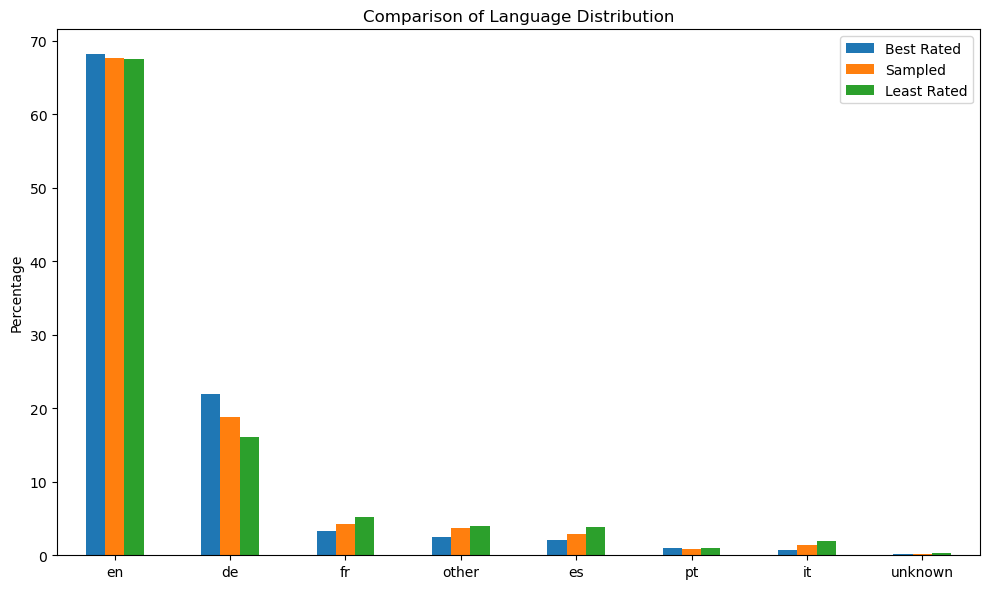

In [31]:
combined_lang_perc = pd.concat([best_rated_lang_perc, sampled_df_lang_perc, least_rated_lang_perc], axis=1)
combined_lang_perc.columns = ['Best Rated', 'Sampled', 'Least Rated']


ax = combined_lang_perc.plot(kind='bar', figsize=(10, 6))
ax.set_ylabel('Percentage')
ax.set_title('Comparison of Language Distribution')
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

The variation is not big but significant. We can observe that the percantage of other-than-English negative reviews increase for Franch, Spanish and Italian, decrease for German.

SENTIMENT ANALYSIS

For the sentiment analysis I am going to focus only to reviews that are in English

In [32]:
# Filter only English rows

In [33]:
best_rated_en = best_rated[best_rated['language'] == 'en']
least_rated_en = least_rated[least_rated['language'] == 'en']
sampled_df_en = sampled_df[sampled_df['language'] == 'en']

In [34]:
best_rated_en.shape

(5504, 48)

In [35]:
least_rated_en.shape

(7752, 48)

In [36]:
sampled_df_en.shape

(6769, 48)

In [37]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment



In [38]:
def retrurn_pos(x):
    return x['pos']

def retrurn_neu(x):
    return x['neu']

def retrurn_neg(x):
    return x['neg']

In [39]:
def create_scores_columns(data_frame):
    data_frame['sentiment_scores'] = data_frame['comments'].apply(get_sentiment_score)
    data_frame['neg_score'] = data_frame['sentiment_scores'].apply(retrurn_neg)
    data_frame['pos_score'] = data_frame['sentiment_scores'].apply(retrurn_pos)
    data_frame['neu_score'] = data_frame['sentiment_scores'].apply(retrurn_neu)

In [40]:
create_scores_columns(best_rated_en)
create_scores_columns(least_rated_en)
create_scores_columns(sampled_df_en)

/var/folders/n7/3f1mct1521j5vz1r2r1xwby80000gn/T/ipykernel_11108/3091757554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['sentiment_scores'] = data_frame['comments'].apply(get_sentiment_score)
/var/folders/n7/3f1mct1521j5vz1r2r1xwby80000gn/T/ipykernel_11108/3091757554.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['neg_score'] = data_frame['sentiment_scores'].apply(retrurn_neg)
/var/folders/n7/3f1mct1521j5vz1r2r1xwby80000gn/T/ipykernel_11108/3091757554.py:4: SettingWithCopy

In [41]:
least_rated_en.head()

,index,review_id,review_date,reviewer_id,reviewer_name,comments,listing_id,listing_url,listing_name,host_id,...,communication_rating,location_rating,value_rating,instant_bookable,business_travel_ready,language,sentiment_scores,neg_score,pos_score,neu_score
44,46,61420583,2016-02-04,15950634,Richard,The host canceled this reservation the day bef...,10008709,https://www.airbnb.com/rooms/10008709,Cozy room in Friedrichshain,47456791,...,10,10,6,f,f,en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.000,1.000
45,47,63012333,2016-02-19,21927977,Markus,"Nice place, room is small but clean, flat is i...",10008709,https://www.airbnb.com/rooms/10008709,Cozy room in Friedrichshain,47456791,...,10,10,6,f,f,en,"{'neg': 0.0, 'neu': 0.558, 'pos': 0.442, 'comp...",0.0,0.442,0.558
46,48,71527986,2016-04-26,64264440,Vladimir,The host canceled this reservation 11 days bef...,10008709,https://www.airbnb.com/rooms/10008709,Cozy room in Friedrichshain,47456791,...,10,10,6,f,f,en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.000,1.000
70,72,57860388,2015-12-29,28831125,Gian Luca,The host canceled this reservation the day bef...,10015667,https://www.airbnb.com/rooms/10015667,SchÃ¶ner Altbau in cooler Kiezlage,14847265,...,0,0,0,f,f,en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.000,1.000
609,617,80843453,2016-06-20,9982744,Nina,The host canceled this reservation 66 days bef...,10037904,https://www.airbnb.com/rooms/10037904,"helle, ruhige Maisonettewohnung",10464825,...,8,10,9,f,f,en,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.000,1.000


In [42]:
least_rated_en['neg_score'].mean()

0.022343137254901963

In [43]:
best_rated_en['neg_score'].mean()

0.0049284156976744185

In [44]:
sampled_df_en['neg_score'].mean()

0.008997193086127937

In [45]:
least_rated_en['neg_score'].median()

0.0

In [46]:
def show_score_dist(data_frame):
    sns.histplot(data=data_frame, x="pos_score", label="pos", color='green')
    sns.histplot(data=data_frame, x="neu_score", label="neu", color='gray')
    sns.histplot(data=data_frame, x="neg_score", label="neg", color='red')
    sns.set(style="darkgrid")
    plt.title("Distribution of score")
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

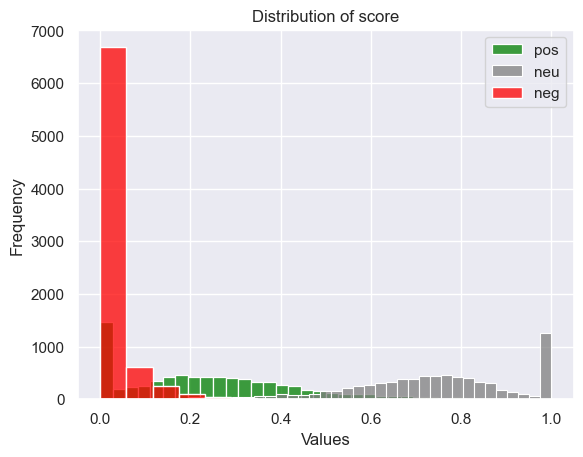

In [70]:
show_score_dist(least_rated_en)

In [48]:
# show_score_dist(sampled_df_en)

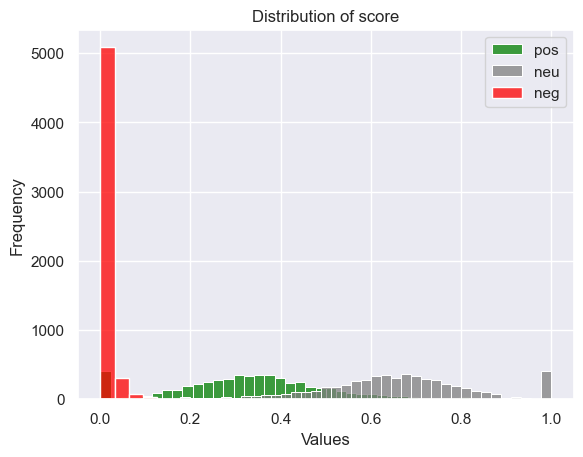

In [71]:
show_score_dist(best_rated_en)

We can observe through the graphs that the main difference between the least and the best rated dfs is in the distribution of the neutral score. Positive score is only partially more right distributed on positive properties reviews.

To double-check this observetion, I am going to print the correlation bìheatmap between the overall score and the positive, neutral and negative score

In [154]:
least_rated_en_sentiment = least_rated_en[['overall_rating', 'neg_score', 'neu_score', 'pos_score']]
best_rated_en_sentiment = best_rated_en[['overall_rating', 'neg_score', 'neu_score', 'pos_score']]

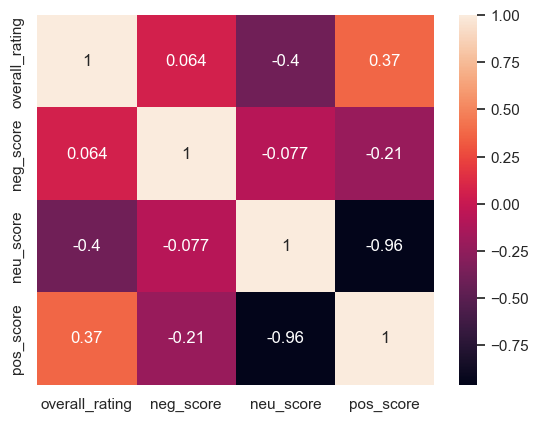

,overall_rating,neg_score,neu_score,pos_score
overall_rating,1.000000,0.064396,-0.397273,0.370718
neg_score,0.064396,1.000000,-0.077279,-0.213044
neu_score,-0.397273,-0.077279,1.000000,-0.957656
pos_score,0.370718,-0.213044,-0.957656,1.000000


In [155]:
correlations_matrix = least_rated_en_sentiment.corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

correlations_matrix

Neutral score has a negative correlation (-0.4) with the overall score. This confirms that a neutral tone in this context is to be perceived as negative. Let's see if the correlation with the best rated properties changes.

In [157]:
best_rated_en_sentiment

,overall_rating,neg_score,neu_score,pos_score
0,100,0.000,0.462,0.538
19622,100,0.041,0.737,0.222
19776,100,0.000,0.633,0.367
19996,100,0.000,0.766,0.234
19997,100,0.000,0.661,0.339
...,...,...,...,...
435496,100,0.000,0.799,0.201
435497,100,0.000,0.799,0.201
435498,100,0.000,0.629,0.371
435499,100,0.000,0.680,0.320


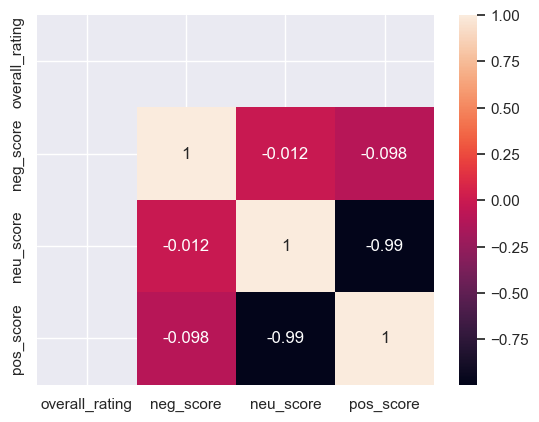

,overall_rating,neg_score,neu_score,pos_score
overall_rating,NaN,NaN,NaN,NaN
neg_score,NaN,1.000000,-0.011563,-0.097653
neu_score,NaN,-0.011563,1.000000,-0.994024
pos_score,NaN,-0.097653,-0.994024,1.000000


In [156]:
correlations_matrix = best_rated_en_sentiment.corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

correlations_matrix

Overall rating in this subdataset is always 100

I am going to analysise the most frequent non-grammatical words

In [67]:
grammatical_words = [
    'the', 'a', 'an', 'and', 'of', 'to', 'in', 'for', 'on', 'with', 'is', 'was', 'i',
    'as', 'by', 'at', 'about', 'from', 'into', 'over', 'after', 'through', 'before',
    'under', 'between', 'above', 'below', 'along', 'near', 'among', 'beside', 'behind',
    'beneath', 'next', 'among', 'upon', 'up', 'down', 'out', 'off', 'around', 'throughout',
    'underneath', 'within', 'without', 'during', 'except', 'until', 'since', 'unless',
    'where', 'when', 'while', 'who', 'which', 'whose', 'whom', 'that', 'these', 'those',
    'this', 'it', 'its', 'he', 'him', 'his', 'she', 'her', 'hers', 'they', 'them', 'their',
    'our', 'us', 'we', 'you', 'your', 'yours', 'I', 'me', 'my', 'mine', '-', 'U'
    ]

def get_most_frequent_words(data_frame, words_to_exclude):

    word_counter = Counter()

    for comment in data_frame['comments']:
        words = comment.split()
        for word in words:
            if word.lower() not in words_to_exclude:
                word_counter.update([word])

    word_frequency = pd.Series(word_counter).sort_values(ascending=False)
    return word_frequency

In [68]:
word_frequency_least_rated_en = get_most_frequent_words(least_rated_en, grammatical_words)

In [69]:
word_frequency_least_rated_en

very         3219
apartment    1934
host         1604
place        1537
but          1435
             ... 
qith            1
football        1
Thorsten        1
beatiful,       1
chec            1
Length: 14999, dtype: int64

In [83]:
word_frequency_best_rated_en = get_most_frequent_words(best_rated_en, grammatical_words)

In [84]:
word_frequency_best_rated_en

very                3183
great               1578
apartment           1501
place               1496
nice                1310
                    ... 
cleanness              1
well.Comfortable       1
concerned.             1
putting                1
ot                     1
Length: 12075, dtype: int64

In [85]:
word_frequency_sampled_en = get_most_frequent_words(sampled_df_en, grammatical_words)

In [86]:
word_frequency_sampled_en

very         3934
apartment    2049
great        2024
place        1834
nice         1471
             ... 
suddenly        1
chilly,         1
cooker.         1
Bike            1
Ema             1
Length: 14886, dtype: int64

Comparing the frequency of words of least rated to the sample

In [58]:
word_frequency_sampled_en.sum()

133668

In [59]:
word_frequency_best_rated_en.sum()

106212

In [60]:
word_frequency_least_rated_en.sum()

138192

To make possible a direct comparison, I am going to reduce proportionally the sum of the occurences of all non-grammatical words to 100000

In [61]:
word_frequency_sampled_en_proportioned = word_frequency_sampled_en * 0.74738
word_frequency_sampled_en_proportioned.sum()

99900.78983999998

In [62]:
word_frequency_best_rated_en_proportioned = word_frequency_best_rated_en * 0.94145
word_frequency_best_rated_en_proportioned.sum()

99993.2874

In [63]:
word_frequency_least_rated_en_proportioned = word_frequency_least_rated_en * 0.72396
word_frequency_least_rated_en_proportioned.sum()

100045.48032

Comparing the frequency of words of best rated to the sample

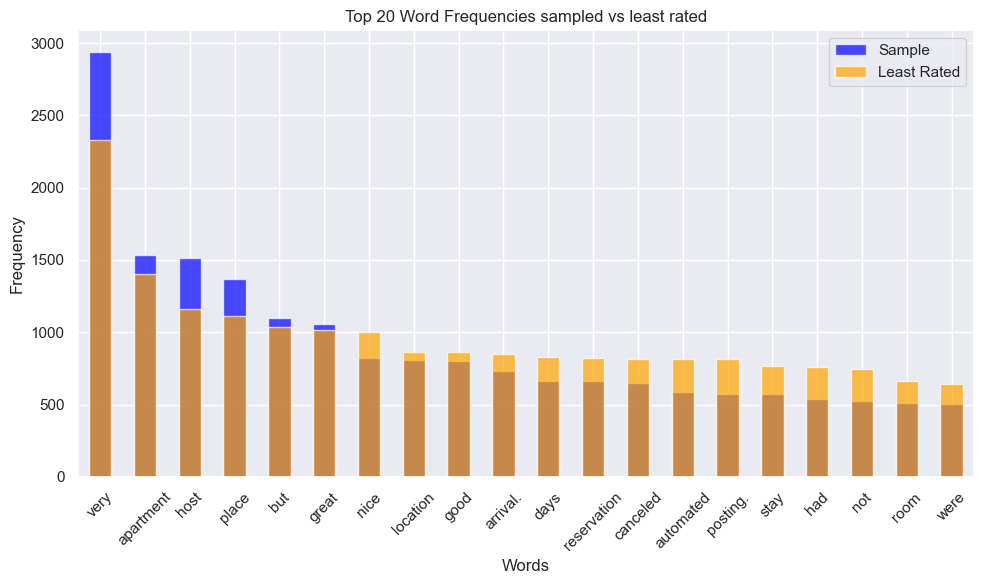

In [64]:
sample_rated_words = word_frequency_sampled_en_proportioned[:20]
least_rated_words = word_frequency_least_rated_en_proportioned[:20]

plt.figure(figsize=(10, 6))  
sample_rated_words.plot(kind='bar', color='blue', alpha=0.7, label='Sample')
least_rated_words.plot(kind='bar', color='orange', alpha=0.7, label='Least Rated')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Word Frequencies sampled vs least rated')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

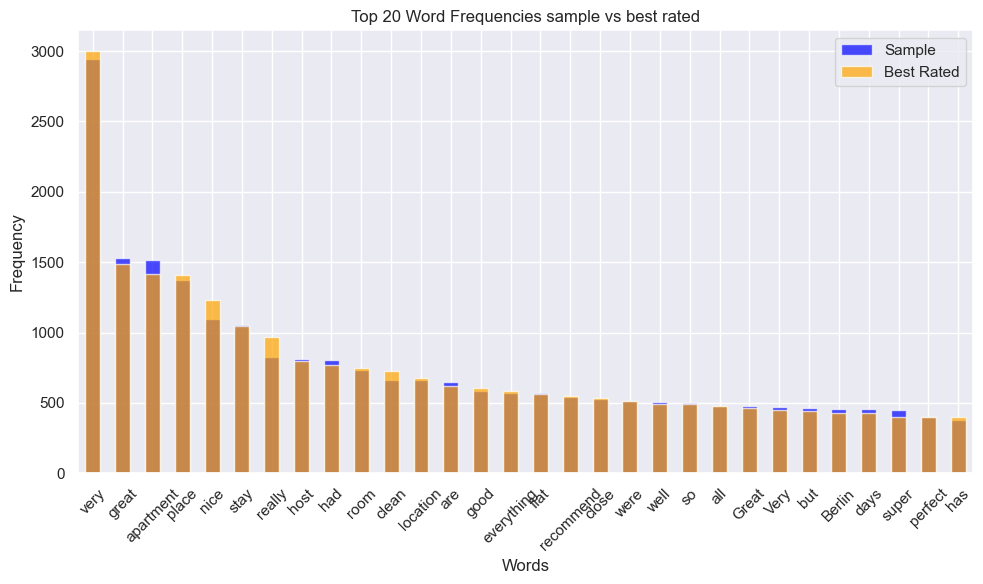

In [65]:
sample_rated_words = word_frequency_sampled_en_proportioned[:30]
best_rated_words = word_frequency_best_rated_en_proportioned[:30]

plt.figure(figsize=(10, 6))  
sample_rated_words.plot(kind='bar', color='blue', alpha=0.7, label='Sample')
best_rated_words.plot(kind='bar', color='orange', alpha=0.7, label='Best Rated')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Word Frequencies sample vs best rated')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

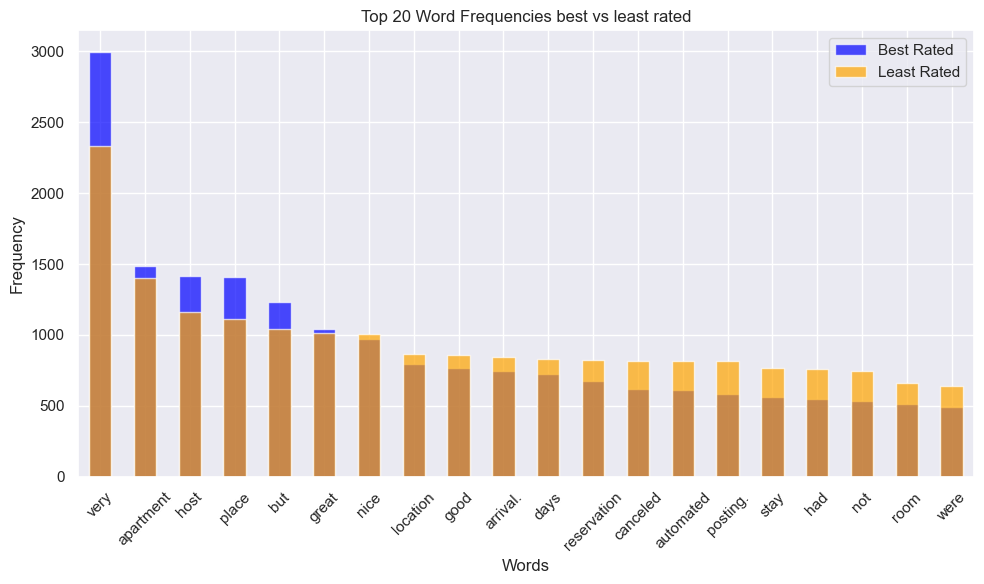

In [66]:
best_rated_words =  word_frequency_best_rated_en_proportioned[:20]
least_rated_words = word_frequency_least_rated_en_proportioned[:20]

plt.figure(figsize=(10, 6))  
best_rated_words.plot(kind='bar', color='blue', alpha=0.7, label='Best Rated')
least_rated_words.plot(kind='bar', color='orange', alpha=0.7, label='Least Rated')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Word Frequencies best vs least rated')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

We can observe the strongest variation between the sample and the least rated reviews. Best reviews have a more significant difference in the intensifier very and more references to the appartment, the host and the place. While least rated more to the location, arrival, reservation. So, it seems they refer more to the experience itself.

Now, let's examine the frequencies on the other main languages.

GERMAN

In [79]:
german_best_rated = best_rated[best_rated['language'] == 'de']
german_least_rated = least_rated[least_rated['language'] == 'de']

In [82]:
german_best_rated.shape

(1775, 48)

In [124]:
common_grammatical_words_german = [
    'der', 'die', 'das', 'ein', 'eine', 'einen',
    'und', 'oder', 'aber', 
    'ist', 'sind', 'hat', 'habe', 'haben',
    'war', 'waren', 'bin', 'bist',
    'sich', 'mich', 'dich', 'ihn', 'sie', 'es', 'wir', 'ihr', 'Sie',
    'ich', 'du', 'er', 'sie', 'es', 'wir', 'ihr', 'sie', 'Sie',
    'mein', 'dein', 'sein', 'ihr', 'unser', 'euer', 'ihr', 'Ihr',
    'meine', 'deine', 'seine', 'ihre', 'unsere', 'eure', 'ihre', 'Ihre',
    'dieser', 'diese', 'dieses', 'jener', 'jene', 'jenes',
    'jeder', 'jede', 'jedes', 'alle', 'alles', 'viel', 'viele',
    'wenig', 'wenige', 'etwas', 'nichts', 'manche', 'manches',
    'manch', 'einige', 'ander', 'andere', 'anderes',
    'meinetwegen', 'nämlich', 'nicht', 'nichtsdestotrotz',
    'sowohl', 'zumindest', ' ',
    'zwecks', 'in', 'mit', 'fà¼r', 'zu', 'uns', 'man', 'auch', '-'
]

word_frequency_best_rated_de = get_most_frequent_words(german_best_rated, common_grammatical_words_german)
word_least_best_rated_de = get_most_frequent_words(german_least_rated, common_grammatical_words_german)


In [125]:
word_frequency_best_rated_de

sehr                 1356
Wohnung               833
super                 473
Sehr                  302
Zimmer                277
                     ... 
abschlieàbar.Man       1
Ruhe.Sehr               1
uvm.Die                 1
Ort.Gerne               1
mitbenutzen             1
Length: 6793, dtype: int64

In [126]:
word_least_best_rated_de

sehr                 1077
Wohnung               837
Lage                  323
gut                   286
super                 241
                     ... 
WG-Zimmer,              1
Service>>>              1
Katya.                  1
unberuecksichtig.       1
anme                    1
Length: 8040, dtype: int64

In [127]:
word_frequency_best_rated_de.sum()

31295

In [128]:
word_least_best_rated_de.sum()

32212

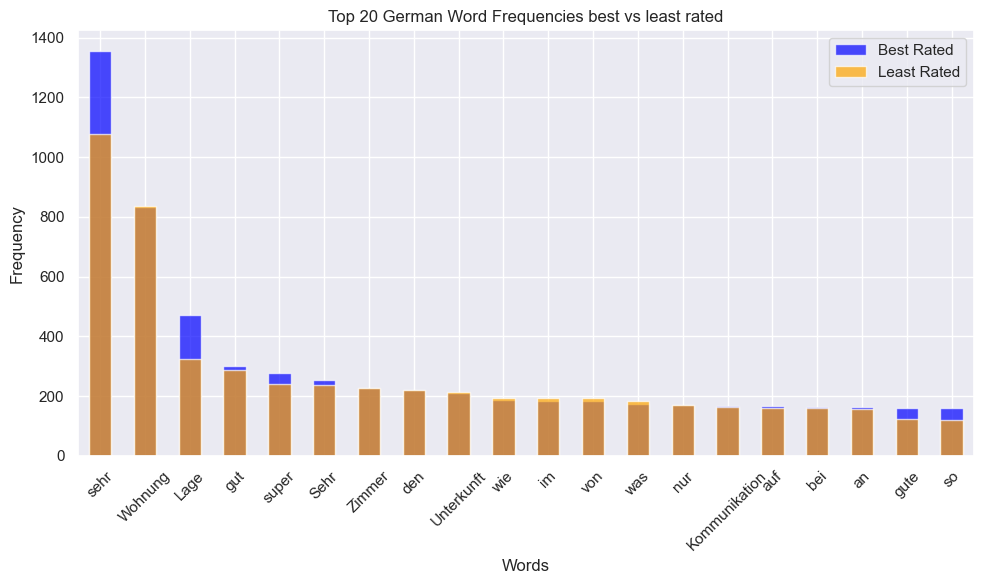

In [129]:
word_frequency_best_rated_de =  word_frequency_best_rated_de[:20]
word_least_best_rated_de = word_least_best_rated_de[:20]

plt.figure(figsize=(10, 6))  
word_frequency_best_rated_de.plot(kind='bar', color='blue', alpha=0.7, label='Best Rated')
word_least_best_rated_de.plot(kind='bar', color='orange', alpha=0.7, label='Least Rated')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 German Word Frequencies best vs least rated')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Also in German, we can observe less frequency of intensifier and positive adjectives. Less rated properties tend to have more neutral occurences